In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def slice_seconds(data, sample_rate, seconds=5, pad_seconds=0):
    # return 2d array of the original data
    n = len(data)
    k = sample_rate*seconds
    pad = sample_rate*pad_seconds
    indexes = np.array(
        [
            np.arange(i, i + k + pad)
            for i in range(0, n, k)
            if i + k + pad <= n
        ]
    )
    indexed = data[indexes]
    return list(zip((np.arange(len(indexed))+1)*5, indexed))

In [2]:
input_df = pd.read_csv("../data/input/train_soundscape_labels.csv")
cens_df = pd.read_pickle("../data/cens/train_soundscapes/data.pkl.gz")

In [3]:
cens_df["_snippet"] = cens_df[["name", "data", "sample_rate"]].apply(lambda x: slice_seconds(x.data, x.sample_rate), axis=1)
exploded = cens_df.explode("_snippet")
exploded["seconds"] = exploded["_snippet"].apply(lambda x: x[0])
exploded["snippet"] = exploded["_snippet"].apply(lambda x: x[1])
exploded["site"] = exploded.name.apply(lambda x: x.split("_")[1])
exploded["audio_id"] = exploded.name.apply(lambda x: x.split("_")[0]).astype(int)
tx_df = input_df.merge(exploded, on=["site", "audio_id", "seconds"])
tx_df["y"] = tx_df.birds.apply(lambda x: 0.0 if x == "nocall" else 1.0)
tx_df.head()

,row_id,site,audio_id,seconds,birds,name,parent,data,sample_rate,cens,cens_sample_rate,path,_snippet,snippet,y
0,7019_COR_5,COR,7019,5,nocall,7019_COR_20190904,train_soundscapes,"[-0.074927814, -0.070623636, -0.012813405, -0....",22050,"[[0.29982088833602566, 0.2964565244514178, 0.2...",10,data/input/train_soundscapes/7019_COR_20190904...,"(5, [-0.074927814, -0.070623636, -0.012813405,...","[-0.074927814, -0.070623636, -0.012813405, -0....",0.0
1,7019_COR_10,COR,7019,10,nocall,7019_COR_20190904,train_soundscapes,"[-0.074927814, -0.070623636, -0.012813405, -0....",22050,"[[0.29982088833602566, 0.2964565244514178, 0.2...",10,data/input/train_soundscapes/7019_COR_20190904...,"(10, [0.012558174, -0.0062861964, -0.010699186...","[0.012558174, -0.0062861964, -0.0106991865, 0....",0.0
2,7019_COR_15,COR,7019,15,nocall,7019_COR_20190904,train_soundscapes,"[-0.074927814, -0.070623636, -0.012813405, -0....",22050,"[[0.29982088833602566, 0.2964565244514178, 0.2...",10,data/input/train_soundscapes/7019_COR_20190904...,"(15, [0.0211886, 0.05153161, 0.0547787, 0.0683...","[0.0211886, 0.05153161, 0.0547787, 0.06838079,...",0.0
3,7019_COR_20,COR,7019,20,nocall,7019_COR_20190904,train_soundscapes,"[-0.074927814, -0.070623636, -0.012813405, -0....",22050,"[[0.29982088833602566, 0.2964565244514178, 0.2...",10,data/input/train_soundscapes/7019_COR_20190904...,"(20, [-0.09674744, -0.12779698, -0.11827926, -...","[-0.09674744, -0.12779698, -0.11827926, -0.110...",0.0
4,7019_COR_25,COR,7019,25,nocall,7019_COR_20190904,train_soundscapes,"[-0.074927814, -0.070623636, -0.012813405, -0....",22050,"[[0.29982088833602566, 0.2964565244514178, 0.2...",10,data/input/train_soundscapes/7019_COR_20190904...,"(25, [0.059325323, 0.049653903, 0.06464528, 0....","[0.059325323, 0.049653903, 0.06464528, 0.06322...",0.0


In [4]:
def mixup(df, alpha=0.4):
    shuf = df.sample(frac=1).reset_index(drop=True)
    x1 = np.stack(df.snippet.values)
    x2 = np.stack(shuf.snippet.values)
    y1 = df.y.values
    y2 = shuf.y.values
    a = np.random.beta(alpha, alpha, (x1.shape[0], 1))
    return (
        a*x1+(1-a)*x2,
        (a.T*y1+(1-a.T)*y2).reshape(-1)
    )

In [5]:
import librosa
import librosa.display
from birdclef.utils import cens_per_sec
from multiprocessing import Pool
from tqdm.auto import tqdm
from functools import partial
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

## pipelined

In [6]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
y = tx_df.y.values
y_pred = np.random.randint(2, size=y.shape[0])
(
    accuracy_score(y_pred, y),
    f1_score(y_pred, y),
    roc_auc_score(y_pred, y)
)

(0.5041666666666667, 0.40972222222222227, 0.4978792254562535)

In [7]:
X = np.stack(tx_df.snippet.values)
y = tx_df.y.values
sample_rate=22050

X_train, X_test, y_train, y_test = train_test_split(X, y)
for _ in range(3):
    _X, _y = mixup(tx_df)
    X_train = np.append(X_train, _X, axis=0)
    y_train = np.append(y_train, _y)
    
convert = partial(
    librosa.feature.chroma_cens, 
    hop_length=cens_per_sec(sample_rate, 4), 
    n_chroma=36,
    win_len_smooth=None
)

n = X_train.shape[0]
with Pool(10) as p:
    conv = list(tqdm(p.imap(convert, X_train), total=n))
X_train = np.array(conv).reshape(n, -1)

n = X_test.shape[0]
with Pool(10) as p:
    conv = list(tqdm(p.imap(convert, X_test), total=n))
X_test = np.array(conv).reshape(n, -1)

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [8]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 1, 756, 1)         0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 1, 784, 1)         0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5408)             

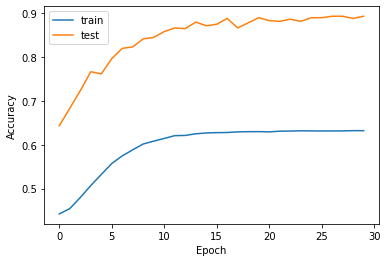

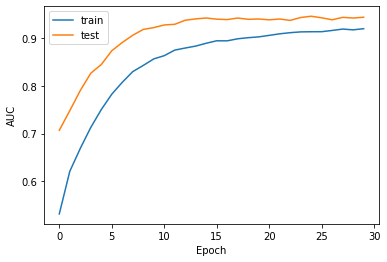

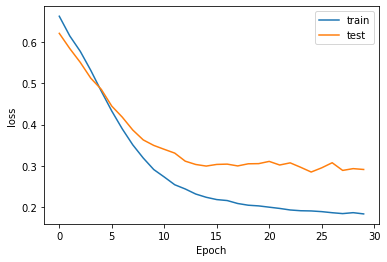

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Reshape, InputLayer
from tensorflow.keras.metrics import BinaryAccuracy, AUC

def get_compiled_model(input_shape=612, output_shape=1):
    n = input_shape
    k = int(np.ceil(np.sqrt(n)))
    rpad = k**2 - n
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Reshape((1, n, 1)))
    model.add(ZeroPadding2D(((0, 0), (0, rpad))))
    model.add(Reshape((k, k, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc")])
    return model

model = get_compiled_model(X_train.shape[1])
model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
model = get_compiled_model(X_train.shape[1])
history = model.fit(
    train_dataset.batch(32),
    epochs=30, 
    validation_data=test_dataset.batch(32)
)
plot_history(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 1, 756, 1)         0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 1, 784, 1)         0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 32)       

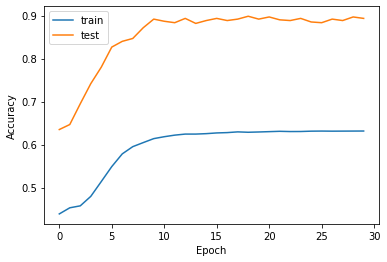

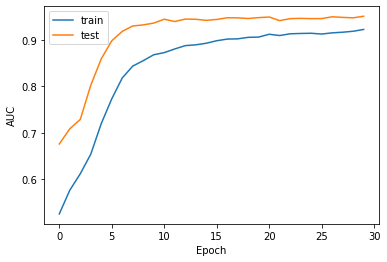

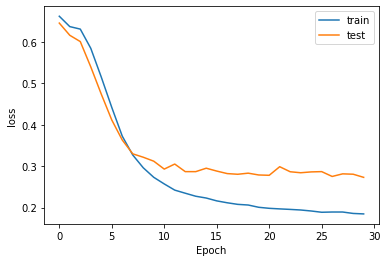

In [16]:
def get_compiled_model(input_shape=612, output_shape=1):
    n = input_shape
    k = int(np.ceil(np.sqrt(n)))
    rpad = k**2 - n
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Reshape((1, n, 1)))
    model.add(ZeroPadding2D(((0, 0), (0, rpad))))
    model.add(Reshape((k, k, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc")])
    return model

model = get_compiled_model(X_train.shape[1])
model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
model = get_compiled_model(X_train.shape[1])
history = model.fit(
    train_dataset.batch(32),
    epochs=30, 
    validation_data=test_dataset.batch(32)
)
plot_history(history)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 1, 756, 1)         0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 1, 784, 1)         0         
_________________________________________________________________
reshape_27 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 32)      

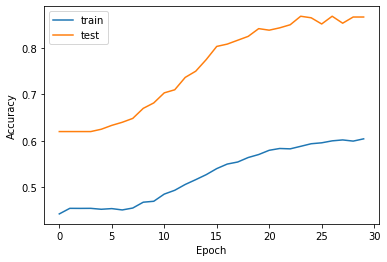

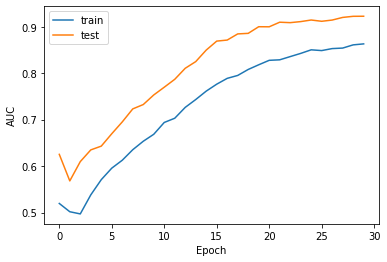

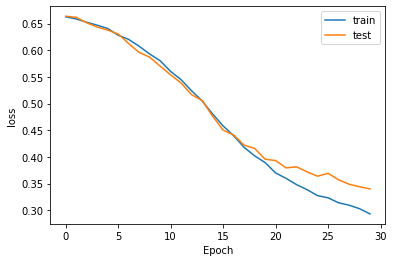

In [19]:
def get_compiled_model(input_shape=612, output_shape=1):
    n = input_shape
    k = int(np.ceil(np.sqrt(n)))
    rpad = k**2 - n
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Reshape((1, n, 1)))
    model.add(ZeroPadding2D(((0, 0), (0, rpad))))
    model.add(Reshape((k, k, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc")])
    return model

model = get_compiled_model(X_train.shape[1])
model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
model = get_compiled_model(X_train.shape[1])
history = model.fit(
    train_dataset.batch(32),
    epochs=30, 
    validation_data=test_dataset.batch(32)
)
plot_history(history)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_48 (Reshape)         (None, 1, 756, 1)         0         
_________________________________________________________________
zero_padding2d_24 (ZeroPaddi (None, 1, 784, 1)         0         
_________________________________________________________________
reshape_49 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 12, 12, 32)      

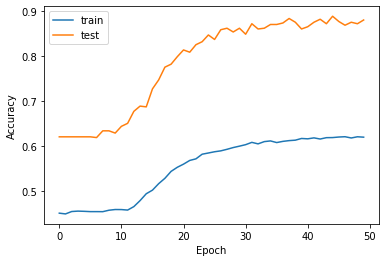

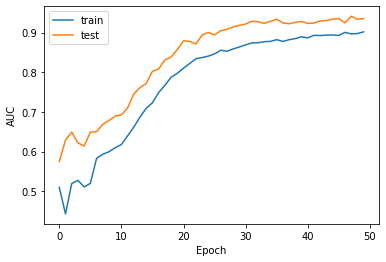

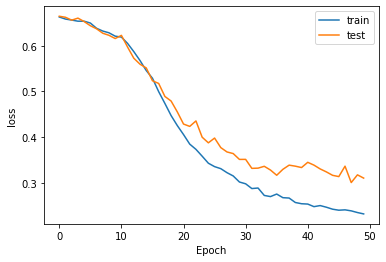

In [26]:
def get_compiled_model(input_shape=612, output_shape=1):
    n = input_shape
    k = int(np.ceil(np.sqrt(n)))
    rpad = k**2 - n
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Reshape((1, n, 1)))
    model.add(ZeroPadding2D(((0, 0), (0, rpad))))
    model.add(Reshape((k, k, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc")])
    return model

model = get_compiled_model(X_train.shape[1])
model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
model = get_compiled_model(X_train.shape[1])
history = model.fit(
    train_dataset.batch(32),
    epochs=50, 
    validation_data=test_dataset.batch(32)
)
plot_history(history)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_40 (Reshape)         (None, 1, 756, 1)         0         
_________________________________________________________________
zero_padding2d_20 (ZeroPaddi (None, 1, 784, 1)         0         
_________________________________________________________________
reshape_41 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 10, 10, 64)      

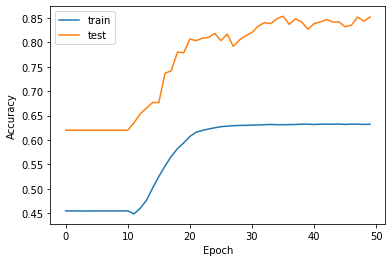

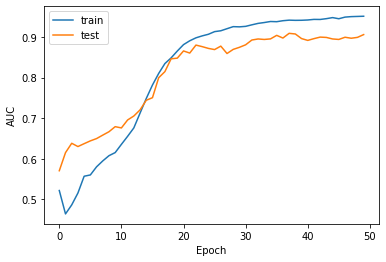

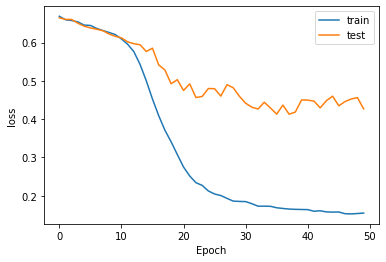

In [24]:
def get_compiled_model(input_shape=612, output_shape=1):
    n = input_shape
    k = int(np.ceil(np.sqrt(n)))
    rpad = k**2 - n
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Reshape((1, n, 1)))
    model.add(ZeroPadding2D(((0, 0), (0, rpad))))
    model.add(Reshape((k, k, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc")])
    return model

model = get_compiled_model(X_train.shape[1])
model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
model = get_compiled_model(X_train.shape[1])
history = model.fit(
    train_dataset.batch(32),
    epochs=50, 
    validation_data=test_dataset.batch(32)
)
plot_history(history)